In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

In [2]:
# --- Variables ---
variables = [
    ContinuousVariable(name="gdp_growth",    description="Annual GDP growth rate (%)", lower_bound=-2.0, upper_bound=8.0, unit="%"),
    ContinuousVariable(name="inflation_rate", description="Annual inflation rate (%)", lower_bound=0.0, upper_bound=10.0, unit="%"),

]

# --- Estimates (marginal + conditional cross-links) ---
estimates = [
    # Marginal: E[GDP growth] = 2.5%
    ExpectationEstimate(id="e_gdp", variable="gdp_growth", expected_value=2.5),
    # Marginal: P(GDP > 6%) = 0.45
    ProbabilityEstimate(
        id="inflation_high",
        proposition=InequalityProposition(variable="inflation_rate", 
                                          variable_type="continuous", 
                                          threshold=7.0, 
                                          is_lower_bound=True),
        probability=0.5,
    ),
    # Conditional: E[GDP growth | Inflation > 7%] = 5.0%
    ConditionalExpectationEstimate(
        id="e_gdp_given_inflation_high",
        variable="gdp_growth",
        conditions=[InequalityProposition(variable="inflation_rate", 
                                        variable_type="continuous", 
                                        threshold=7.0, 
                                        is_lower_bound=True)],
        expected_value=5.0,
    ),
]

print(f"{len(variables)} variables, {len(estimates)} estimates")

2 variables, 3 estimates


In [7]:
from calibrated_response.energy_models.markov_random import MarkovRandomField
import jax.numpy as jnp

mrf = MarkovRandomField.from_estimates(variables, estimates, bins_per_var=5)
params_pytree = mrf.zero_params()
params = mrf.pack_params(params_pytree)
energy_fn = mrf.energy_fn_flat
init_x = jnp.array([2.0, 1.0])  # Initial guess for (gdp_growth, inflation_rate)
energy_value = energy_fn(params, init_x)
print(f"Energy at initial guess: {energy_value}")

Energy at initial guess: 0.0


In [9]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=256,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.006,

    l2_regularization=1e-4,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config,
                              energy_fn=energy_fn, init_theta=params)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="gdp_growth")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

[MaxEntSolver] iter   50  max_err=0.163502  mean_err=0.121439  mean_squared_err=0.016344  accept=0.818  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.121435  mean_err=0.068257  mean_squared_err=0.005630  accept=0.670  step_size=0.14619
[MaxEntSolver] iter  150  max_err=0.078228  mean_err=0.047150  mean_squared_err=0.002888  accept=0.643  step_size=0.12424
[MaxEntSolver] iter  200  max_err=0.067432  mean_err=0.052645  mean_squared_err=0.002932  accept=0.637  step_size=0.11671
[MaxEntSolver] iter  250  max_err=0.095917  mean_err=0.037986  mean_squared_err=0.002867  accept=0.646  step_size=0.12117
[MaxEntSolver] iter  300  max_err=0.078213  mean_err=0.049222  mean_squared_err=0.002714  accept=0.620  step_size=0.12580
[MaxEntSolver] iter  350  max_err=0.088470  mean_err=0.033749  mean_squared_err=0.002169  accept=0.615  step_size=0.11817
[MaxEntSolver] iter  400  max_err=0.088244  mean_err=0.045105  mean_squared_err=0.002803  accept=0.615  step_size=0.12268
[MaxEntSolver] iter  450

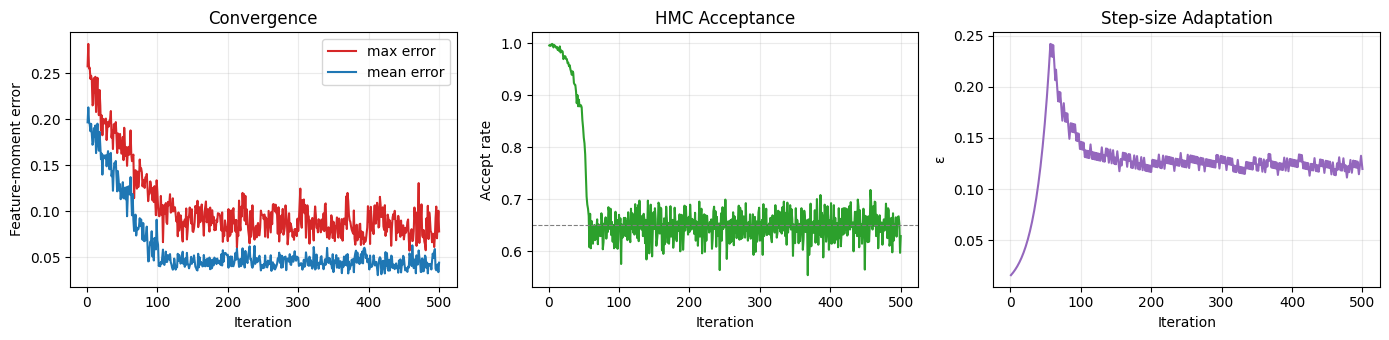

Final max error:  0.07796
Final mean error: 0.04396
Final accept rate: 0.629


In [14]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [11]:
energy_model = info["energy_model"]
samples = energy_model.sample(n_samples=1000)

Text(0.5, 1.02, 'Marginal Distributions of GDP Growth and Inflation Rate')

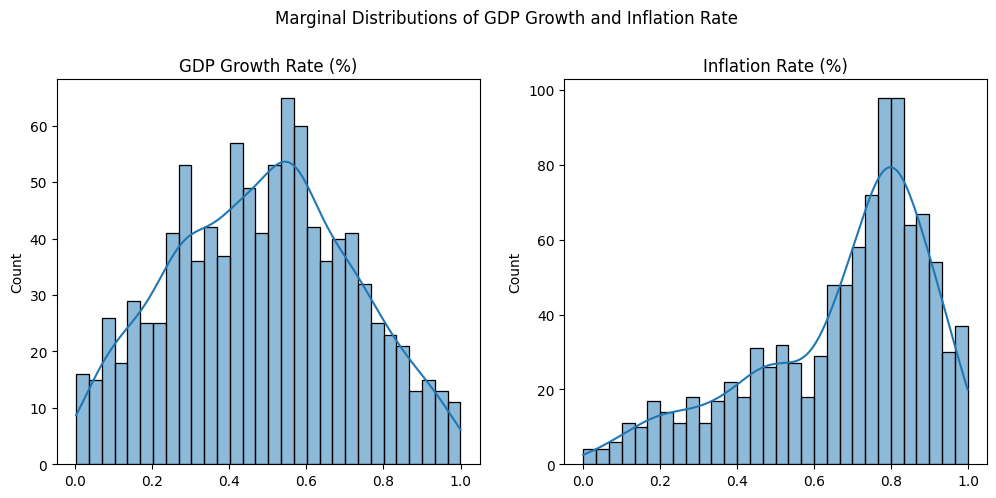

In [13]:
# plot histogram of samples
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(samples[:, 0], bins=30, kde=True, ax=ax[0])
sns.histplot(samples[:, 1], bins=30, kde=True, ax=ax[1])
ax[0].set_title("GDP Growth Rate (%)")  
ax[1].set_title("Inflation Rate (%)")
plt.suptitle("Marginal Distributions of GDP Growth and Inflation Rate", y=1.02)

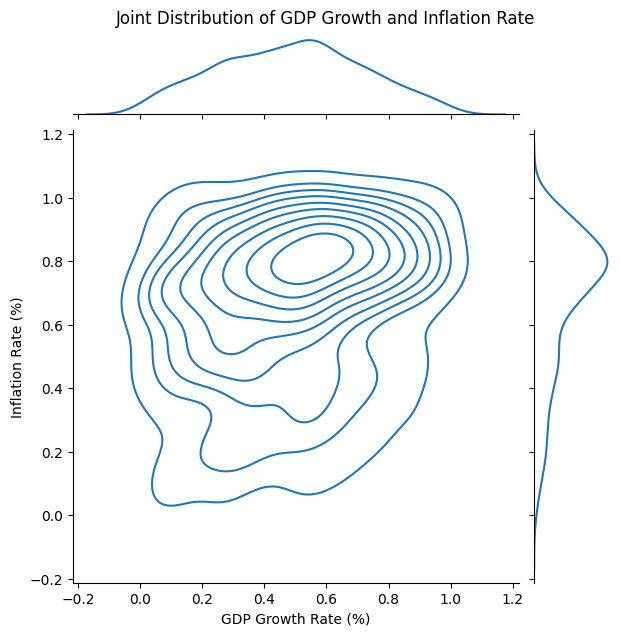

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.xlabel("GDP Growth Rate (%)")
plt.ylabel("Inflation Rate (%)")
plt.suptitle("Joint Distribution of GDP Growth and Inflation Rate", y=1.02)
plt.show()